# Exploratory Data Analysis

## Variables Description

- **flight_id**: A unique identifier assigned to each flight.
- **date**: The date when the flight took place.
- **callsign**: The encrypted callsign associated with the flight.
- **adep**: The code of the departure airport.
- **name_adep**: The name of the departure airport.
- **country_code_adep**: The country code of the departure airport.
- **ades**: The code of the destination airport.
- **name_ades**: The name of the destination airport.
- **country_code_ades**: The country code of the destination airport.
- **actual_offblock_time**: The time when the aircraft started to move from its parking position.
- **arrival_time**: The time of arrival at the destination airport.
- **aircraft_type**: The type of aircraft used for the flight.
- **wtc**: The wake turbulence category of the aircraft.
- **airline**: The encrypted identifier of the airline operating the flight.
- **flight_duration**: The duration of the flight in minutes.
- **taxiout_time**: The time spent taxiing out from the departure airport.
- **flown_distance**: The distance flown during the flight in kilometers.
- **tow**: The target variable representing the actual TakeOff Weight (TOW) of the aircraft.

In [1]:
!pip install meteostat

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from meteostat import Stations, Daily
from datetime import timedelta
import multiprocessing as mp

In [3]:
# Load the datasets
challenge_set = pd.read_csv('./data/challenge_set.csv')
submission_set = pd.read_csv('./data/submission_set.csv')
trajectories_set = pd.read_csv('./data/trajectory_features.csv')

challenge_set = trajectories_set[trajectories_set['flight_id'].isin(challenge_set['flight_id'])]
submission_set = trajectories_set[trajectories_set['flight_id'].isin(submission_set['flight_id'])]

# Display the first few rows of the datasets to understand their structure
challenge_set.T

105791  \
flight_id                                             248763780   
date                                                 2022-01-01   
callsign                       3840d84f25d3f5fcc0a1be3076bb4039   
adep                                                       EGLL   
name_adep                                       London Heathrow   
country_code_adep                                            GB   
ades                                                       EICK   
name_ades                                                  Cork   
country_code_ades                                            IE   
actual_offblock_time                       2022-01-01T13:46:00Z   
arrival_time                               2022-01-01T15:04:56Z   
aircraft_type                                              A320   
wtc                                                           M   
airline                        a73f82288988b79be490c6322f4c32ed   
flight_duration                                              61   
taxiout_time                                                 18   
flown_distance                                              321   
tow                                                     54748.0   
track_variation_ARR_100                              124.339907   
track_variation_DEP_40                                39.704139   
track_variation_ENR                                   18.449496   
average_vertical_rate_ARR_100                      -1290.828729   
average_vertical_rate_DEP_40                        1794.412698   
average_vertical_rate_ENR                            577.924812   
average_airspeed_ARR_100                             144.183237   
average_airspeed_DEP_40                              152.698285   
average_airspeed_ENR                                 216.901773   
groundspeed_ARR_100                                  145.300942   
groundspeed_DEP_40                                   147.559687   
groundspeed_ENR                                      188.101807   
wind_distance_ARR_100                               1649.422621   
wind_distance_DEP_40                               -2579.698967   
wind_distance_ENR                                  -45960.80701   
average_temperature_ARR_100                          254.028168   
average_temperature_DEP_40                           271.189236   
average_temperature_ENR                               227.11362   
average_humidity_ARR_100                                0.00232   
average_humidity_DEP_40                                0.003253   
average_humidity_ENR                                   0.000087   
specific_energy_ARR_100                             7185.351086   
specific_energy_DEP_40                             84354.189095   
specific_energy_ENR                               144961.839766   
flown_distance_ARR_100                            209778.210671   
flown_distance_DEP_40                              74129.419615   
flown_distance_ENR                                298889.740138   
average_altitude_ARR_100                           15722.634669   
average_altitude_DEP_40                             9336.656746   
average_altitude_ENR                               30307.033208   
specific_energy                                    40764.557911   

                                                         105792  \
flight_id                                             248760618   
date                                                 2022-01-01   
callsign                       f6f610e73002b8892a239a81321f7f1d   
adep                                                       LEBL   
name_adep                                             Barcelona   
country_code_adep                                            ES   
ades                                                       KMIA   
name_ades                                                 Miami   
country_code_ades                                            US   
actual_offblock_time                

In [4]:
# Ensure you are working with a copy of the DataFrame
challenge_set = challenge_set.copy()
submission_set = submission_set.copy()

# Convert 'date' columns to datetime format
challenge_set['date'] = pd.to_datetime(challenge_set['date'])
submission_set['date'] = pd.to_datetime(submission_set['date'])

# Find the min and max dates in both datasets
min_challenge_date = challenge_set['date'].min()
max_challenge_date = challenge_set['date'].max()

min_submission_date = submission_set['date'].min()
max_submission_date = submission_set['date'].max()

(min_challenge_date, max_challenge_date, min_submission_date, max_submission_date)

(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'))

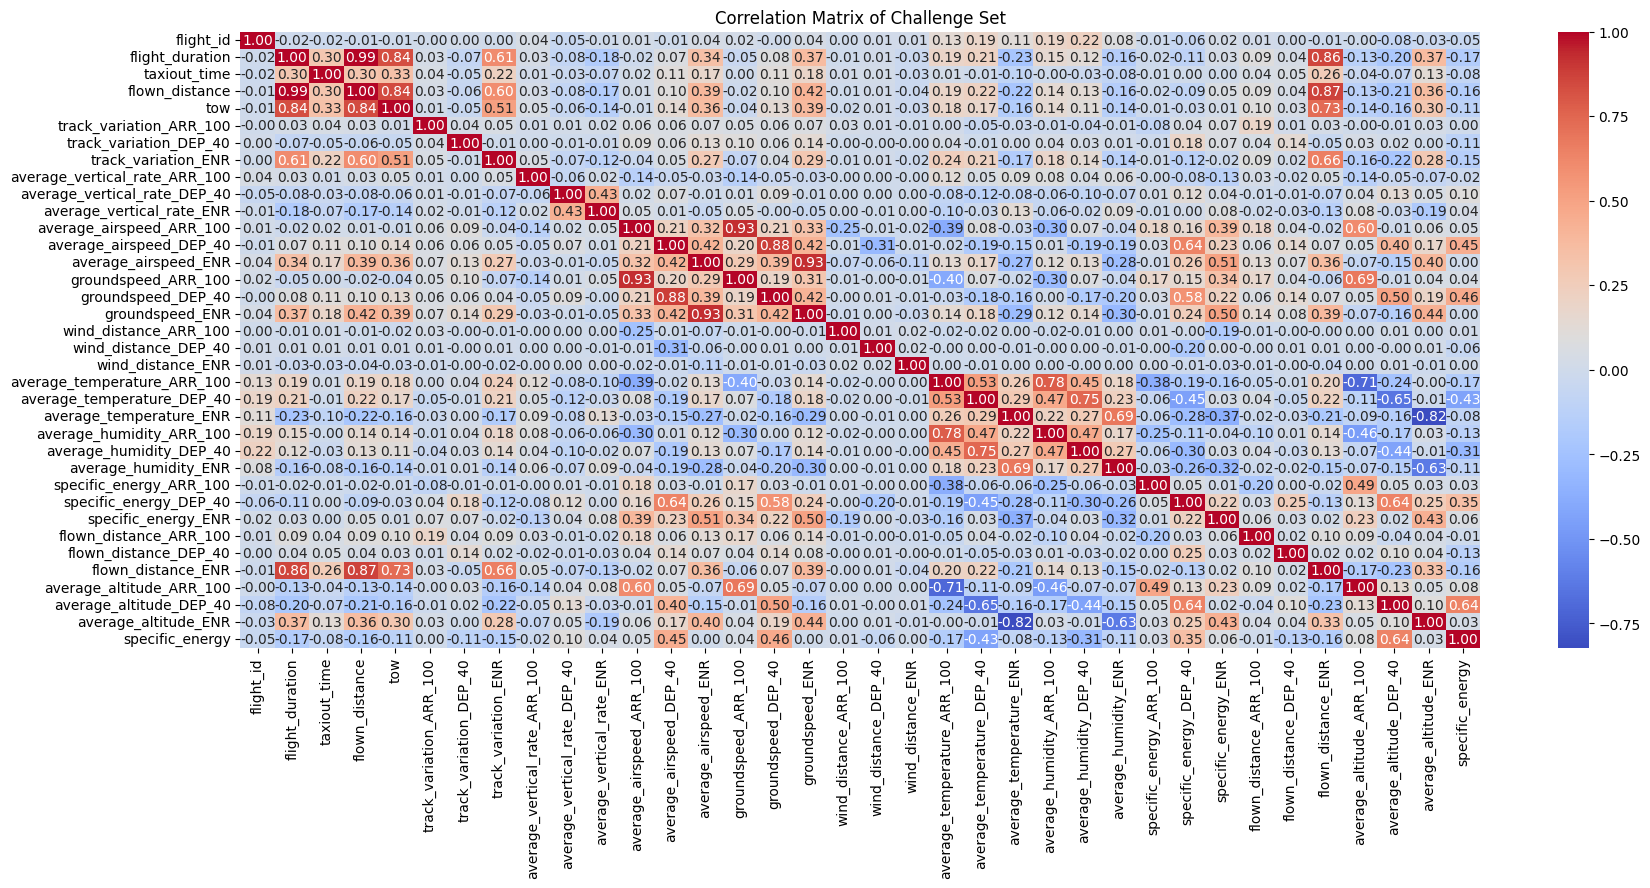

(          flight_id                           date  flight_duration  \
 count  3.683710e+05                         368371    368371.000000   
 mean   2.535221e+08  2022-07-14 06:52:50.653499136       145.962049   
 min    2.487506e+08            2022-01-01 00:00:00         8.000000   
 25%    2.512290e+08            2022-04-29 00:00:00        59.000000   
 50%    2.536200e+08            2022-07-20 00:00:00       100.000000   
 75%    2.559066e+08            2022-10-04 00:00:00       164.000000   
 max    2.580745e+08            2022-12-31 00:00:00      1013.000000   
 std    2.688971e+06                            NaN       139.415997   
 
         taxiout_time  flown_distance            tow  track_variation_ARR_100  \
 count  368371.000000   368371.000000  368371.000000            344953.000000   
 mean       13.490858     1022.422902   79511.807653                74.451965   
 min         0.000000       19.000000   14944.000000                 0.000000   
 25%        10.000000     

In [5]:
# Summary statistics of the challenge set
challenge_summary = challenge_set.describe()

# Check for missing values
missing_values = challenge_set.isnull().sum()

# Drop non-numeric columns before computing the correlation matrix
numeric_challenge_set = challenge_set.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numeric_challenge_set.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

In [6]:
# Checking for missing values in each column and displaying the result as a DataFrame
missing_values = trajectories_set.isnull().sum()
missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])
missing_values_df['Percentage'] = (missing_values_df['Missing Values'] / len(trajectories_set)) * 100
missing_values_df

Missing Values  Percentage
flight_id                                   0    0.000000
date                                        0    0.000000
callsign                                    0    0.000000
adep                                        0    0.000000
name_adep                                   0    0.000000
country_code_adep                           0    0.000000
ades                                        0    0.000000
name_ades                                   0    0.000000
country_code_ades                           0    0.000000
actual_offblock_time                        0    0.000000
arrival_time                                0    0.000000
aircraft_type                               0    0.000000
wtc                                         0    0.000000
airline                                     0    0.000000
flight_duration                             0    0.000000
taxiout_time                                0    0.000000
flown_distance                              0    0.000000
tow                                    105791   22.311151
track_variation_ARR_100                 30099    6.347830
track_variation_DEP_40                  76676   16.170845
track_variation_ENR                     36400    7.676701
average_vertical_rate_ARR_100           30102    6.348463
average_vertical_rate_DEP_40            76677   16.171055
average_vertical_rate_ENR               36402    7.677123
average_airspeed_ARR_100                30329    6.396337
average_airspeed_DEP_40                 76768   16.190247
average_airspeed_ENR                    36410    7.678810
groundspeed_ARR_100                     30099    6.347830
groundspeed_DEP_40                      76676   16.170845
groundspeed_ENR                         36400    7.676701
wind_distance_ARR_100                   30044    6.336231
wind_distance_DEP_40                    76575   16.149544
wind_distance_ENR                       36399    7.676490
average_temperature_ARR_100             30283    6.386636
average_temperature_DEP_40              76721   16.180335
average_temperature_ENR                 36409    7.678599
average_humidity_ARR_100                30283    6.386636
average_humidity_DEP_40                 76721   16.180335
average_humidity_ENR                    36409    7.678599
specific_energy_ARR_100                199632   42.102066
specific_energy_DEP_40                  79692   16.806914
specific_energy_ENR                     37597    7.929147
flown_distance_ARR_100                  30044    6.336231
flown_distance_DEP_40                   76575   16.149544
flown_distance_ENR                      36399    7.676490
average_altitude_ARR_100                30044    6.336231
average_altitude_DEP_40                 76575   16.149544
average_altitude_ENR                    36399    7.676490
specific_energy                         80326   16.940624

In [7]:
list(challenge_set.columns)

['flight_id',
 'date',
 'callsign',
 'adep',
 'name_adep',
 'country_code_adep',
 'ades',
 'name_ades',
 'country_code_ades',
 'actual_offblock_time',
 'arrival_time',
 'aircraft_type',
 'wtc',
 'airline',
 'flight_duration',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'av

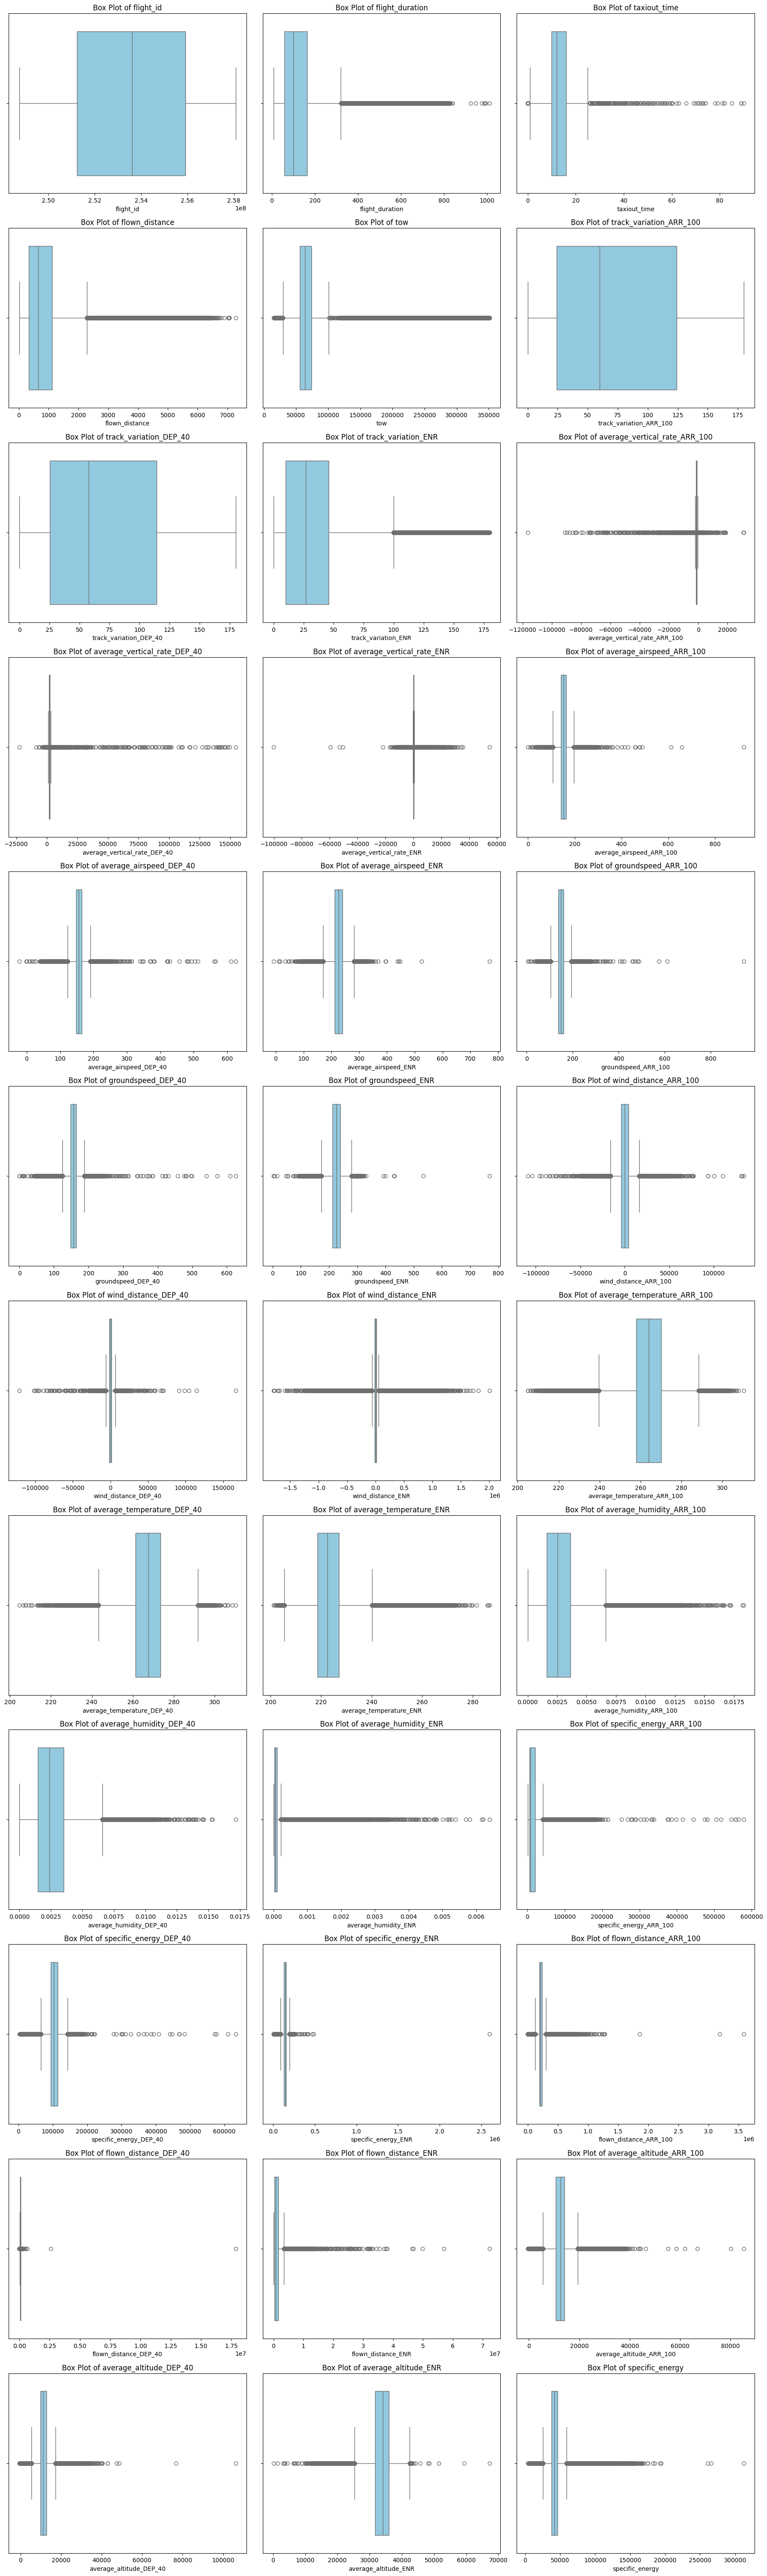

In [8]:
# Extract all numerical columns from the dataset
numerical_columns = challenge_set.select_dtypes(include=['number']).columns

# Set the number of plots per row (3 per row for narrow columns)
plots_per_row = 3
total_plots = len(numerical_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

# Set up the figure size, adjusting for the number of rows
plt.figure(figsize=(18, rows * 5))  # Adjust the width and height based on rows

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(rows, plots_per_row, i)  # Arrange the plots in the grid with three plots per row
    
    # Plotting a boxplot for each numerical feature
    sns.boxplot(x=challenge_set[feature], color='skyblue')
    
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(f'{feature}')
    
plt.tight_layout()
plt.show()

In [9]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = challenge_set['country_code_adep'].unique()
ades_countries = challenge_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AO', 'AT', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BJ', 'BR', 'BY', 'CA', 'CD', 'CG', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ES', 'ET', 'FI', 'FR', 'GB', 'GE', 'GH', 'GI', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KR', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NP', 'OM', 'PA', 'PH', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SN', 'SO', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'VE', 'VN', 'XK', 'ZA']


In [10]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = submission_set['country_code_adep'].unique()
ades_countries = submission_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries_sub = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries_sub))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BH', 'BY', 'CA', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ER', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MX', 'NL', 'NO', 'OM', 'PA', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SI', 'SK', 'SL', 'SN', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'XK', 'ZA']


In [11]:
set(all_countries_sub) - set(all_countries)

{'ER'}

In [12]:
set(all_countries) - set(all_countries_sub)

{'AO',
 'AW',
 'BB',
 'BD',
 'BJ',
 'BR',
 'CD',
 'CG',
 'ET',
 'GH',
 'GI',
 'KR',
 'MU',
 'MY',
 'NG',
 'NP',
 'PH',
 'SD',
 'SO',
 'VE',
 'VN'}

In [18]:
import pandas as pd

def extract_time_features(df):
    # Ensure 'actual_offblock_time' is in datetime format, coerce invalid formats to NaT
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'], errors='coerce')
    
    # Print rows where conversion to datetime failed
    invalid_times = df['actual_offblock_time'].isnull()
    if invalid_times.any():
        print(f"Warning: {invalid_times.sum()} invalid 'actual_offblock_time' values found. Showing some examples:")
        print(df.loc[invalid_times, ['actual_offblock_time']].head())
    
    # Only apply .dt accessors to valid datetime entries
    valid_times = df['actual_offblock_time'].notnull()
    
    # Extract time features for valid times only
    df.loc[valid_times, 'offblock_hour'] = df.loc[valid_times, 'actual_offblock_time'].dt.hour
    df.loc[valid_times, 'offblock_minute'] = df.loc[valid_times, 'actual_offblock_time'].dt.minute
    df.loc[valid_times, 'offblock_day_of_week'] = df.loc[valid_times, 'actual_offblock_time'].dt.dayofweek

    return df




In [20]:

# Create additional duration-based features
def create_duration_features(df):
    df = df.copy()
    # Replace zero or negative values in flight_duration to avoid division errors
    df.loc[:, 'flight_duration'] = df['flight_duration'].replace(0, np.nan)
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].replace(0, np.nan)
    
    # Fill NaN values in taxiout_time with the median or a reasonable default
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].fillna(df['taxiout_time'].median())
    
    # Calculate the ratio of taxiout time to flight duration with error handling
    df.loc[:, 'taxi_ratio'] = df.apply(lambda row: row['taxiout_time'] / row['flight_duration'] 
                                       if pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in taxi_ratio with the median of taxi_ratio
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].fillna(df['taxi_ratio'].median())
    
    # Calculate the average flight speed (distance per minute) with error handling
    df.loc[:, 'flight_speed'] = df.apply(lambda row: row['flown_distance'] / row['flight_duration'] 
                                         if pd.notnull(row['flown_distance']) and pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in flight_speed with the median value or a reasonable default
    df.loc[:, 'flight_speed'] = df['flight_speed'].fillna(df['flight_speed'].median())
    
    # Normalize taxi_ratio by the median value to control for large values
    df.loc[:, 'normalized_taxi_ratio'] = df['taxi_ratio'] / df['taxi_ratio'].median()
    
    # Categorical features for flight duration buckets
    df.loc[:, 'flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 60, 180, 300, np.inf], 
                                                   labels=['Very Short', 'Short', 'Medium', 'Long'], right=False)
    
    # Speed per distance feature for more detailed analysis
    df.loc[:, 'speed_per_distance'] = df.apply(lambda row: row['flight_speed'] / row['flown_distance'] 
                                               if pd.notnull(row['flight_speed']) and pd.notnull(row['flown_distance']) else np.nan, axis=1)
    
    # Fill NaN values in speed_per_distance with the median value or a reasonable default
    df.loc[:, 'speed_per_distance'] = df['speed_per_distance'].fillna(df['speed_per_distance'].median())
    
    # Cumulative mean of flight speed to capture trends over time (if data is ordered by time)
    df.loc[:, 'cumulative_avg_speed'] = df['flight_speed'].expanding().mean()
    
    # Handle edge cases and set up conditions for further analysis
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].replace([np.inf, -np.inf], np.nan)
    df.loc[:, 'flight_speed'] = df['flight_speed'].replace([np.inf, -np.inf], np.nan)
    
    return df

# Group airports by region based on country codes
def group_airports_by_region(df):
    df = df.copy()
    # Define country groups for regions
    europe_countries = ['GB', 'FR', 'DE', 'ES', 'IT', 'SE', 'CH', 'NL', 'AT', 'IE', 'BE', 'DK', 'FI', 'GR', 'HU', 
                        'IS', 'LT', 'LU', 'LV', 'MT', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'CZ', 'EE', 'BG', 'CY']
    north_america_countries = ['US', 'CA', 'MX']
    south_america_countries = ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'UY', 'PY', 'BO', 'EC', 'GY', 'SR']
    middle_east_countries = ['AE', 'SA', 'IL', 'IR', 'IQ', 'JO', 'KW', 'OM', 'QA', 'BH', 'LB', 'SY', 'YE']
    asia_countries = ['JP', 'CN', 'KR', 'IN', 'PK', 'BD', 'VN', 'PH', 'TH', 'MY', 'ID', 'SG', 'MN', 'KZ', 'TM', 'UZ', 'KG']
    africa_countries = ['ZA', 'NG', 'EG', 'DZ', 'MA', 'KE', 'TZ', 'GH', 'ET', 'CI', 'SN', 'SD', 'AO', 'LR', 'RW', 'ER']
    other_countries = set(df['country_code_adep'].unique()).union(set(df['country_code_ades'].unique())) - set(
        europe_countries + north_america_countries + south_america_countries + middle_east_countries + asia_countries + africa_countries)

    # Apply region categorization based on country codes
    def categorize_region(code):
        if code in europe_countries:
            return 'Europe'
        elif code in north_america_countries:
            return 'North America'
        elif code in south_america_countries:
            return 'South America'
        elif code in middle_east_countries:
            return 'Middle East'
        elif code in asia_countries:
            return 'Asia'
        elif code in africa_countries:
            return 'Africa'
        elif code in other_countries:
            return 'Other'
        else:
            return 'Unknown'

    # Apply region classification for adep and ades
    df.loc[:, 'adep_region'] = df['country_code_adep'].apply(categorize_region)
    df.loc[:, 'ades_region'] = df['country_code_ades'].apply(categorize_region)

    return df

# Extract country-related features
def extract_country_features(df):
    df = df.copy()
    # Basic feature indicating if the flight is within the same country
    df.loc[:, 'same_country_flight'] = (df['country_code_adep'] == df['country_code_ades']).astype(int)

    # Feature indicating if the flight is within the same region
    df.loc[:, 'same_region_flight'] = (df['adep_region'] == df['ades_region']).astype(int)

    # Flight direction based on regions: North-South, East-West, or Other
    df.loc[:, 'flight_direction'] = df.apply(
        lambda row: 'North-South' if row['adep_region'] in ['North America', 'Europe'] and row['ades_region'] in ['South America', 'Africa']
        else 'East-West' if row['adep_region'] in ['Europe', 'Asia'] and row['ades_region'] in ['North America']
        else 'Other', axis=1)

    # Create a feature indicating if the flight is intercontinental
    intercontinental_regions = ['Europe', 'North America', 'South America', 'Middle East', 'Asia', 'Africa']
    df.loc[:, 'is_intercontinental'] = df.apply(
        lambda row: 1 if row['adep_region'] in intercontinental_regions and 
                         row['ades_region'] in intercontinental_regions and 
                         row['adep_region'] != row['ades_region'] else 0, axis=1)
    return df

In [32]:
def create_interactions(df):
    # ARR phase interaction feature
    df.loc[:, 'airspeed_specific_energy_ARR'] = df['average_airspeed_ARR_100'] * df['specific_energy_ARR_100']
    
    # DEP phase interaction feature (corrected column names)
    df.loc[:, 'airspeed_specific_energy_DEP'] = df['average_airspeed_DEP_40'] * df['specific_energy_DEP_40']
    
    # ENR phase interaction feature
    df.loc[:, 'airspeed_specific_energy_ENR'] = df['average_airspeed_ENR'] * df['specific_energy_ENR']
    
    return df


In [35]:
def create_bins(df):
    df = df.copy()
    # Create bins (discretization) for temperature and humidity into 5 categories
    df.loc[:, 'temperature_bins_ARR'] = pd.cut(df['average_temperature_ARR_100'], bins=5, labels=False)
    df.loc[:, 'humidity_bins_DEP'] = pd.cut(df['average_humidity_DEP_40'], bins=5, labels=False)  # Updated column name
    return df


In [38]:
def create_ratios(df):
    df = df.copy()
    # Create ratio features such as vertical rate to airspeed for arrival and departure phases
    df.loc[:, 'vertical_rate_airspeed_ratio_ARR'] = df['average_vertical_rate_ARR_100'] / df['average_airspeed_ARR_100']
    df.loc[:, 'vertical_rate_airspeed_ratio_DEP'] = df['average_vertical_rate_DEP_40'] / df['average_airspeed_DEP_40']  # Updated column names
    return df


In [39]:

# Function to remove original columns after feature extraction
def remove_columns(df, columns_to_remove):
    # Remove original columns since features have been extracted
    df = df.drop(columns_to_remove, axis=1)
    return df




In [40]:
# List of columns to remove after feature extraction
columns_to_remove = ['name_adep', 'name_ades', 'country_code_adep', 'country_code_ades', 'flight_id', 'callsign', 
                     'actual_offblock_time', 'arrival_time', 'flight_duration']


# Apply all functions to the challenge set
challenge_set = challenge_set.copy()
cleaned_challenge_set = extract_time_features(challenge_set)
print("extract_time_features completed")

cleaned_challenge_set = create_duration_features(cleaned_challenge_set)
print("create_duration_features completed")

cleaned_challenge_set = group_airports_by_region(cleaned_challenge_set)
print("group_airports_by_region completed")

cleaned_challenge_set = extract_country_features(cleaned_challenge_set)
print("extract_country_features completed")

cleaned_challenge_set = create_interactions(cleaned_challenge_set)
print("create_interactions completed")

cleaned_challenge_set = create_bins(cleaned_challenge_set)
print("create_bins completed")

cleaned_challenge_set = create_ratios(cleaned_challenge_set)
print("create_ratios completed")

cleaned_challenge_set = remove_columns(cleaned_challenge_set, columns_to_remove)
print("remove_columns completed")

# Apply all functions to the submission set
submission_set = submission_set.copy()
cleaned_submission_set = extract_time_features(submission_set)
print("extract_time_features completed on submission_set")

cleaned_submission_set = create_duration_features(cleaned_submission_set)
print("create_duration_features completed on submission_set")

cleaned_submission_set = group_airports_by_region(cleaned_submission_set)
print("group_airports_by_region completed on submission_set")

cleaned_submission_set = extract_country_features(cleaned_submission_set)
print("extract_country_features completed on submission_set")

cleaned_submission_set = create_interactions(cleaned_submission_set)
print("create_interactions completed on submission_set")

cleaned_submission_set = create_bins(cleaned_submission_set)
print("create_bins completed on submission_set")

cleaned_submission_set = create_ratios(cleaned_submission_set)
print("create_ratios completed on submission_set")

cleaned_submission_set = remove_columns(cleaned_submission_set, columns_to_remove)
print("remove_columns completed on submission_set")

# Display the transposed first few rows of the updated challenge set for review
cleaned_challenge_set.head().T

extract_time_features completed


create_duration_features completed
group_airports_by_region completed
extract_country_features completed
create_interactions completed
create_bins completed
create_ratios completed
remove_columns completed
extract_time_features completed on submission_set


create_duration_features completed on submission_set
group_airports_by_region completed on submission_set
extract_country_features completed on submission_set
create_interactions completed on submission_set
create_bins completed on submission_set
create_ratios completed on submission_set
remove_columns completed on submission_set


105791               105792  \
date                              2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                             EGLL                 LEBL   
ades                                             EICK                 KMIA   
aircraft_type                                    A320                 B772   
wtc                                                 M                    H   
...                                               ...                  ...   
airspeed_specific_energy_ENR          31442479.991853      36998699.742842   
temperature_bins_ARR                              2.0                  3.0   
humidity_bins_DEP                                 0.0                  0.0   
vertical_rate_airspeed_ratio_ARR            -8.952696            -6.973417   
vertical_rate_airspeed_ratio_DEP            11.751361            12.234285   

                                               105793               105794  \
date                              2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                             ESSA                 LSZH   
ades                                             KORD                 KPHL   
aircraft_type                                    A333                 B788   
wtc                                                 H                    H   
...                                               ...                  ...   
airspeed_specific_energy_ENR          19032920.012174      24760589.191667   
temperature_bins_ARR                              2.0                  3.0   
humidity_bins_DEP                                 0.0                  0.0   
vertical_rate_airspeed_ratio_ARR            -6.082271            -5.159291   
vertical_rate_airspeed_ratio_DEP            12.949346            13.587494   

                                               105795  
date                              2022-01-01 00:00:00  
adep                                             EIDW  
ades                                             EGLL  
aircraft_type                                    A21N  
wtc                                                 M  
...                                               ...  
airspeed_specific_energy_ENR          34734208.275384  
temperature_bins_ARR                              NaN  
humidity_bins_DEP                                 0.0  
vertical_rate_airspeed_ratio_ARR                  NaN  
vertical_rate_airspeed_ratio_DEP            15.681694  

[62 rows x 5 columns]

In [41]:
# Extracting unique aircraft types from each set
challenge_aircraft_types = set(challenge_set['aircraft_type'].unique())
submission_aircraft_types = set(submission_set['aircraft_type'].unique())

# Aircraft types in challenge_set but not in submission_set
only_in_challenge = challenge_aircraft_types - submission_aircraft_types
print("Aircraft types only in challenge_set:", only_in_challenge)

# Aircraft types in submission_set but not in challenge_set
only_in_submission = submission_aircraft_types - challenge_aircraft_types
print("Aircraft types only in submission_set:", only_in_submission)

Aircraft types only in challenge_set: {'A310', 'C56X'}
Aircraft types only in submission_set: set()


In [42]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [43]:
# Load the FAA Aircraft Characteristics Database from the uploaded Excel file
file_path = "./extra_data/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.xlsx"

# Load the FAA dataset and select relevant columns
faa_data = pd.read_excel(file_path, sheet_name='ACD_Data')

# Select relevant columns for merging
# faa_relevant_columns = [
#     'FAA_Designator', 'Manufacturer', 'Model_FAA', 'Physical_Class_Engine', 'Num_Engines', 'ADG', 'TDG', 'Approach_Speed_knot', 'MTOW_lb', 
#     'Wingspan_ft_without_winglets_sharklets', 'Length_ft', 'Tail_Height_at_OEW_ft', 'Wheelbase_ft', 'Cockpit_to_Main_Gear_ft', 'Main_Gear_Width_ft', 
#     'MALW_lb', 'Main_Gear_Config', 'Parking_Area_ft2', 'Class', 'FAA_Weight', 'CWT', 'One_Half_Wake_Category', 'Two_Wake_Category_Appx_A', 
#     'Two_Wake_Category_Appx_B', 'Rotor_Diameter_ft', 'SRS', 'Registration_Count', 'Total_IFR_Operations_2021_2022']

faa_relevant_columns = [
    'FAA_Designator',
    'Physical_Class_Engine',
    'Num_Engines',
    'Approach_Speed_knot',
    'Wingspan_ft_without_winglets_sharklets',
    'Wingspan_ft_with_winglets_sharklets',
    'Length_ft',
    'Tail_Height_at_OEW_ft',
    'Wheelbase_ft',
    'Cockpit_to_Main_Gear_ft',
    'Main_Gear_Width_ft',
    'MTOW_lb',
    'MALW_lb',
    'Main_Gear_Config',
    'Parking_Area_ft2',
    'FAA_Weight',
    'Total_IFR_Operations_2021_2022'
]

# Prepare the FAA data for merging
faa_clean = faa_data[faa_relevant_columns].copy()  # Use .copy() to avoid the warning

# Convert MTOW and MALW from pounds to kilograms for consistency
faa_clean.loc[:, 'MTOW_kg'] = faa_clean['MTOW_lb'] * 0.453592
faa_clean.loc[:, 'MALW_kg'] = faa_clean['MALW_lb'] * 0.453592

# Merge the cleaned_challenge_set with FAA data on aircraft_type and FAA_Designator
cleaned_challenge_set = cleaned_challenge_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Merge the cleaned_submission_set with FAA data on aircraft_type and FAA_Designator
cleaned_submission_set = cleaned_submission_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Drop unnecessary columns
cleaned_challenge_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)
cleaned_submission_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)

# Display the transposed cleaned_challenge_set for review
cleaned_challenge_set.T

0                    1       \
date                            2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                           EGLL                 LEBL   
ades                                           EICK                 KMIA   
aircraft_type                                  A320                 B772   
wtc                                               M                    H   
...                                             ...                  ...   
Parking_Area_ft2                            16354.4              44939.7   
FAA_Weight                                    Large                Heavy   
Total_IFR_Operations_2021_2022              2765265               222264   
MTOW_kg                                78000.133912           297556.352   
MALW_kg                                 65999.90396            213188.24   

                                             2                    3       \
date                            2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                           ESSA                 LSZH   
ades                                           KORD                 KPHL   
aircraft_type                                  A333                 B788   
wtc                                               H                    H   
...                                             ...                  ...   
Parking_Area_ft2                            44473.5              39602.0   
FAA_Weight                                    Heavy                Heavy   
Total_IFR_Operations_2021_2022               206739               208774   
MTOW_kg                               241999.950248            227929.98   
MALW_kg                               186999.652288            172364.96   

                                             4                    5       \
date                            2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                           EIDW                 ENGM   
ades                                           EGLL                 LEAL   
aircraft_type                                  A21N                 A20N   
wtc                                               M                    M   
...                                             ...                  ...   
Parking_Area_ft2                            19253.0              16358.3   
FAA_Weight                                    Large                Large   
Total_IFR_Operations_2021_2022               490022              1002340   
MTOW_kg                                94999.854888          78999.85068   
MALW_kg                                79199.884752         67399.688872   

                                             6                    7       \
date                            2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                                           EGAC                 LTFM   
ades                                           EGLL                 LYBE   
aircraft_type                                  A320                 B738   
wtc                                               M                    M   
...                                             ...                  ...   
Parking_Area_ft2                            16354.4              16487.0   
FAA_Weight                                    Large                Large   
Total_IFR_Operations_2021_2022              2765265              4459952   
MTOW_kg                                78000.133912           79015.7264   
MALW_kg                                 65999.90396           66349.1698   

                                             8                    9       ...  \
date                            2022-01-01 00:00:00  2022-01-01 00:00:00  ...   
adep                                           KLAX                 LTFM  ...   
ades                                           LTFM                 LTAC  ...   
aircraft_type                                  B789                 A

In [44]:
# Check for unique aircraft types in the cleaned challenge set
unique_aircraft_types = cleaned_challenge_set['aircraft_type'].unique()

# Check which aircraft types from the challenge set are not present in the FAA data
missing_aircraft_types = [atype for atype in unique_aircraft_types if atype not in faa_data['FAA_Designator'].unique()]

missing_aircraft_types

[]

In [45]:
# Load the GlobalAirportDatabase.txt into a DataFrame
columns_global = ['ICAO', 'IATA', 'Airport Name', 'City/Town', 'Country', 
                  'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds', 'Latitude Direction',
                  'Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds', 'Longitude Direction',
                  'Altitude', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees']
global_airports = pd.read_csv('./extra_data/GlobalAirportDatabase.txt', sep=':', header=None, names=columns_global)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
global_airports = global_airports[['ICAO', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees', 'Altitude']]

# Load the airports.dat file (assuming previous naming and structure)
columns_openflights = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 
                       'Type', 'Source']
openflights_airports = pd.read_csv('./extra_data/airports.dat', header=None, names=columns_openflights)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
openflights_airports = openflights_airports[['ICAO', 'Latitude', 'Longitude', 'Altitude']]
openflights_airports.rename(columns={'Latitude': 'Latitude Decimal Degrees', 
                                     'Longitude': 'Longitude Decimal Degrees'}, inplace=True)

# Concatenate both datasets, removing duplicates based on ICAO codes
airports = pd.concat([global_airports, openflights_airports]).drop_duplicates(subset=['ICAO'])

# Display the combined dataset to verify the merge
airports.head()

ICAO  Latitude Decimal Degrees  Longitude Decimal Degrees  Altitude
0  AYGA                    -6.082                    145.392      1610
1  AYLA                     0.000                      0.000         0
2  AYMD                    -5.207                    145.789         7
3  AYMH                    -5.826                    144.296      1643
4  AYNZ                    -6.570                    146.726        73

In [46]:
# Backup
backup_challenge_set = cleaned_challenge_set.copy()

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports

# Merge for adep (departure airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

# Display the transposed DataFrame to confirm the correct columns are retained
cleaned_challenge_set.T

0                    1                    2       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGLL                 LEBL                 ESSA   
ades                           EICK                 KMIA                 KORD   
aircraft_type                  A320                 B772                 A333   
wtc                               M                    H                    H   
...                             ...                  ...                  ...   
Altitude_adep                  25.0                  4.0                 38.0   
ICAO_ades                      EICK                 KMIA                 KORD   
Latitude_ades                51.843               25.793               41.979   
Longitude_ades               -8.492              -80.291              -87.904   
Altitude_ades                 154.0                  3.0                204.0   

                             3                    4                    5       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LSZH                 EIDW                 ENGM   
ades                           KPHL                 EGLL                 LEAL   
aircraft_type                  B788                 A21N                 A20N   
wtc                               H                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                 432.0                 74.0                208.0   
ICAO_ades                      KPHL                 EGLL                 LEAL   
Latitude_ades                39.872               51.477               38.282   
Longitude_ades              -75.241               -0.461               -0.558   
Altitude_ades                  12.0                 25.0                 44.0   

                             6                    7                    8       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGAC                 LTFM                 KLAX   
ades                           EGLL                 LYBE                 LTFM   
aircraft_type                  A320                 B738                 B789   
wtc                               M                    M                    H   
...                             ...                  ...                  ...   
Altitude_adep                   5.0                325.0                 39.0   
ICAO_ades                      EGLL                 LYBE                 LTFM   
Latitude_ades                51.477               44.818            41.275278   
Longitude_ades               -0.461               20.309            28.751944   
Altitude_ades                  25.0                103.0                325.0   

                             9       ...               368361  \
date            2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                           LTFM  ...                 LIRF   
ades                           LTAC  ...                 EBBR   
aircraft_type                  A321  ...                 A320   
wtc                               M  ...                    M   
...                             ...  ...                  ...   
Altitude_adep                 325.0  ...                  4.0   
ICAO_ades                      LTAC  ...                 EBBR   
Latitude_ades                40.128  ...               50.902   
Longitude_ades               32.995  ...                4.499   
Altitude_ades                 953.0  ...                 57.0   

                             368362               368363               368364  \
date            2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-31 00:00:00   
adep                           EGLL                 LTFM                 LSZH   
ades                           LSZH                 LIMC                 LGTS   
aircr

In [47]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = cleaned_challenge_set.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = cleaned_challenge_set[cleaned_challenge_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = cleaned_challenge_set[cleaned_challenge_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(9, {'HSSK', 'LFTM', 'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [48]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = cleaned_challenge_set[cleaned_challenge_set.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values.T

1                    2                    3       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LEBL                 ESSA                 LSZH   
ades                           KMIA                 KORD                 KPHL   
aircraft_type                  B772                 A333                 B788   
wtc                               H                    H                    H   
...                             ...                  ...                  ...   
Altitude_adep                   4.0                 38.0                432.0   
ICAO_ades                      KMIA                 KORD                 KPHL   
Latitude_ades                25.793               41.979               39.872   
Longitude_ades              -80.291              -87.904              -75.241   
Altitude_ades                   3.0                204.0                 12.0   

                             4                    5                    6       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EIDW                 ENGM                 EGAC   
ades                           EGLL                 LEAL                 EGLL   
aircraft_type                  A21N                 A20N                 A320   
wtc                               M                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                  74.0                208.0                  5.0   
ICAO_ades                      EGLL                 LEAL                 EGLL   
Latitude_ades                51.477               38.282               51.477   
Longitude_ades               -0.461               -0.558               -0.461   
Altitude_ades                  25.0                 44.0                 25.0   

                             7                    8                    9       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LTFM                 KLAX                 LTFM   
ades                           LYBE                 LTFM                 LTAC   
aircraft_type                  B738                 B789                 A321   
wtc                               M                    H                    M   
...                             ...                  ...                  ...   
Altitude_adep                 325.0                 39.0                325.0   
ICAO_ades                      LYBE                 LTFM                 LTAC   
Latitude_ades                44.818            41.275278               40.128   
Longitude_ades               20.309            28.751944               32.995   
Altitude_ades                 103.0                325.0                953.0   

                             12      ...               368360  \
date            2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                           ESSA  ...                 EBBR   
ades                           ESMS  ...                 EIDW   
aircraft_type                  CRJ9  ...                 A320   
wtc                               M  ...                    M   
...                             ...  ...                  ...   
Altitude_adep                  38.0  ...                 57.0   
ICAO_ades                      ESMS  ...                 EIDW   
Latitude_ades                 55.53  ...               53.421   
Longitude_ades               13.371  ...                -6.27   
Altitude_ades                  72.0  ...                 74.0   

                             368361               368362               368363  \
date            2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-31 00:00:00   
adep                           LIRF                 EGLL                 LTFM   
ades                           EBBR                 LSZH                 LIMC   
aircr

In [49]:
# Applying the same transformations for submission_set as described for challenge_set

# Backup
backup_submission_set = cleaned_submission_set.copy()

# Filter updated_airports to include only ICAO codes present in cleaned_submission_set (adep and ades)
relevant_icaos_submission = cleaned_submission_set['adep'].unique().tolist() + cleaned_submission_set['ades'].unique().tolist()
filtered_airports_submission = airports[airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

cleaned_submission_set.T

0                    1                    2       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LTFJ                 EBBR                 KMIA   
ades                           LFLL                 KJFK                 EGLL   
aircraft_type                  B738                 A333                 B77W   
wtc                               M                    H                    H   
...                             ...                  ...                  ...   
Altitude_adep                 312.0                 57.0                  3.0   
ICAO_ades                      LFLL                 KJFK                 EGLL   
Latitude_ades                45.726                40.64               51.477   
Longitude_ades                5.091              -73.779               -0.461   
Altitude_ades                 251.0                  4.0                 25.0   

                             3                    4                    5       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGCN                 EIDW                 LTFJ   
ades                           LEAL                 LFLL                 LTAC   
aircraft_type                  B38M                 A320                 B738   
wtc                               M                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                  55.0                 74.0                312.0   
ICAO_ades                      LEAL                 LFLL                 LTAC   
Latitude_ades                38.282               45.726               40.128   
Longitude_ades               -0.558                5.091               32.995   
Altitude_ades                  44.0                251.0                953.0   

                             6                    7                    8       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGLL                 LSZH                 EGLL   
ades                           EIDW                 EDDH                 EICK   
aircraft_type                  A320                 A320                 A320   
wtc                               M                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                  25.0                432.0                 25.0   
ICAO_ades                      EIDW                 EDDH                 EICK   
Latitude_ades                53.421                53.63               51.843   
Longitude_ades                -6.27                9.988               -8.492   
Altitude_ades                  74.0                 17.0                154.0   

                             9       ...               105781  \
date            2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                           LEMD  ...                 BKPR   
ades                           EIDW  ...                 LSGG   
aircraft_type                  A320  ...                 BCS3   
wtc                               M  ...                    M   
...                             ...  ...                  ...   
Altitude_adep                 610.0  ...               1789.0   
ICAO_ades                      EIDW  ...                 LSGG   
Latitude_ades                53.421  ...               46.238   
Longitude_ades                -6.27  ...                6.109   
Altitude_ades                  74.0  ...                431.0   

                             105782               105783               105784  \
date            2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-30 00:00:00   
adep                           LTFJ                 KORD                 KJFK   
ades                           LFLL                 EGLL                 LEBL   
aircr

In [50]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = cleaned_submission_set.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = cleaned_submission_set[cleaned_submission_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = cleaned_submission_set[cleaned_submission_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(6, {'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VOGO', 'ZMCK'})

In [51]:
# Coordinates for the given ICAO codes
new_airports = {
    'ICAO': ['CYHZ', 'EDDE', 'KDAB', 'KRFD', 'LIPO', 'LTAP', 'HSSK', 'LFTM', 'LTFG', 
             'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'],
    'Latitude Decimal Degrees': [44.8800, 50.9798, 29.1799, 42.1954, 45.4289, 40.0714, 
                                 15.5895, 40.9769, 36.2994, 38.7262, 43.0613, 40.3581, 
                                 23.8433, 15.3808, 48.1357],
    'Longitude Decimal Degrees': [-63.5086, 10.9581, -81.0581, -89.0972, 10.3306, 32.5644, 
                                  32.5532, 28.8146, 32.3006, 30.6015, 74.4776, 71.7450, 
                                  90.3978, 73.8314, 114.6460],
    'Altitude': [145, 316, 11, 224, 109, 535, 386, 35, 28, 1003, 627, 577, 8, 56, 751]
}

# Convert new airports data to DataFrame
new_airports_df = pd.DataFrame(new_airports)

# Append the new rows to the existing DataFrame
updated_airports = pd.concat([airports, new_airports_df], ignore_index=True)

updated_airports = updated_airports.drop_duplicates(subset=['ICAO'])

In [52]:
# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_challenge = backup_challenge_set['adep'].unique().tolist() + backup_challenge_set['ades'].unique().tolist()
filtered_airports_challenge = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_challenge)]

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
challenge_set_updated = pd.merge(
    backup_challenge_set, filtered_airports_challenge, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
challenge_set_updated = pd.merge(
    challenge_set_updated, filtered_airports_challenge, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True)


# Display the transposed DataFrame to confirm the correct columns are retained
challenge_set_updated.T

0                    1                    2       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGLL                 LEBL                 ESSA   
ades                           EICK                 KMIA                 KORD   
aircraft_type                  A320                 B772                 A333   
wtc                               M                    H                    H   
...                             ...                  ...                  ...   
Altitude_adep                    25                    4                   38   
ICAO_ades                      EICK                 KMIA                 KORD   
Latitude_ades                51.843               25.793               41.979   
Longitude_ades               -8.492              -80.291              -87.904   
Altitude_ades                   154                    3                  204   

                             3                    4                    5       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LSZH                 EIDW                 ENGM   
ades                           KPHL                 EGLL                 LEAL   
aircraft_type                  B788                 A21N                 A20N   
wtc                               H                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                   432                   74                  208   
ICAO_ades                      KPHL                 EGLL                 LEAL   
Latitude_ades                39.872               51.477               38.282   
Longitude_ades              -75.241               -0.461               -0.558   
Altitude_ades                    12                   25                   44   

                             6                    7                    8       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGAC                 LTFM                 KLAX   
ades                           EGLL                 LYBE                 LTFM   
aircraft_type                  A320                 B738                 B789   
wtc                               M                    M                    H   
...                             ...                  ...                  ...   
Altitude_adep                     5                  325                   39   
ICAO_ades                      EGLL                 LYBE                 LTFM   
Latitude_ades                51.477               44.818            41.275278   
Longitude_ades               -0.461               20.309            28.751944   
Altitude_ades                    25                  103                  325   

                             9       ...               368361  \
date            2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                           LTFM  ...                 LIRF   
ades                           LTAC  ...                 EBBR   
aircraft_type                  A321  ...                 A320   
wtc                               M  ...                    M   
...                             ...  ...                  ...   
Altitude_adep                   325  ...                    4   
ICAO_ades                      LTAC  ...                 EBBR   
Latitude_ades                40.128  ...               50.902   
Longitude_ades               32.995  ...                4.499   
Altitude_ades                   953  ...                   57   

                             368362               368363               368364  \
date            2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-31 00:00:00   
adep                           EGLL                 LTFM                 LSZH   
ades                           LSZH                 LIMC                 LGTS   
aircr

In [53]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = challenge_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = challenge_set_updated[challenge_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = challenge_set_updated[challenge_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(0, set())

In [54]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = challenge_set_updated[challenge_set_updated.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values

date  adep  ades aircraft_type wtc  \
1      2022-01-01  LEBL  KMIA          B772   H   
2      2022-01-01  ESSA  KORD          A333   H   
3      2022-01-01  LSZH  KPHL          B788   H   
4      2022-01-01  EIDW  EGLL          A21N   M   
5      2022-01-01  ENGM  LEAL          A20N   M   
...           ...   ...   ...           ...  ..   
368365 2022-12-31  EDDV  LOWW          E195   M   
368366 2022-12-31  LFPG  KMIA          B788   H   
368367 2022-12-31  LTFM  EDDB          A21N   M   
368369 2022-12-31  LFPG  EIDW          A21N   M   
368370 2022-12-31  LEMD  KJFK          B772   H   

                                 airline  taxiout_time  flown_distance  \
1       5543e4dc327359ffaf5b9c0e6faaf0e1          13.0            4193   
2       8be5c854fd664bcb97fb543339f74770          15.0            3770   
3       5543e4dc327359ffaf5b9c0e6faaf0e1          11.0            3607   
4       a73f82288988b79be490c6322f4c32ed          14.0             305   
5       8be5c854fd664bcb97fb543339f74770          27.0            1434   
...                                  ...           ...             ...   
368365  5d407cb11cc29578cc3e292e743f5393           8.0             416   
368366  5543e4dc327359ffaf5b9c0e6faaf0e1          21.0            4046   
368367  6351ec1b849adacc0cbb3b1313d8d39b          25.0             946   
368369  a73f82288988b79be490c6322f4c32ed          12.0             466   
368370  5543e4dc327359ffaf5b9c0e6faaf0e1          16.0            3213   

                  tow  track_variation_ARR_100  ...        MTOW_kg  \
1       185441.000000               179.318890  ...  297556.352000   
2       230396.000000               179.638848  ...  241999.950248   
3       157615.000000                 0.208347  ...  227929.980000   
4        70318.447226                      NaN  ...   94999.854888   
5        57721.000000               129.426353  ...   78999.850680   
...               ...                      ...  ...            ...   
368365   40868.000000                70.340447  ...   52290.085760   
368366  163438.000000               174.768738  ...  227929.980000   
368367   78707.000000                62.544950  ...   94999.854888   
368369   72611.161024                48.439184  ...   94999.854888   
368370  195373.000000                      NaN  ...  297556.352000   

              MALW_kg  ICAO  Latitude_adep  Longitude_adep  Altitude_adep  \
1       213188.240000  LEBL      41.297000        2.078000              4   
2       186999.652288  ESSA      59.652000       17.919000             38   
3       172364.960000  LSZH      47.465000        8.549000            432   
4        79199.884752  EIDW      53.421000       -6.270000             74   
5        67399.688872  ENGM      60.194000       11.100000            208   
...               ...   ...            ...             ...            ...   
368365   45800.091424  EDDV      52.461000        9.685000             56   
368366  172364.960000  LFPG      49.013000        2.550000            120   
368367   79199.884752  LTFM      41.275278       28.751944            325   
368369   79199.884752  LFPG      49.013000        2.550000            120   
368370  213188.240000  LEMD      40.472000       -3.561000            610   

        ICAO_ades  Latitude_ades  Longitude_ades  Altitude_ades  
1            KMIA         25.793         -80.291              3  
2            KORD         41.979         -87.904            204  
3            KPHL         39.872         -75.241             12  
4            EGLL         51.477          -0.461             25  
5            LEAL         38.282          -0.558             44  
...           ...            ...             ...            ...  
368365       LOWW         48.110          16.570            183  
368366       KMIA         25.793         -80.291              3  
368367       EDDB         52.380          13.523             48  
368369       EIDW         53.421          -6.270             74  
368370       KJFK  

In [55]:
# Applying the same transformations for submission_set as described for challenge_set

# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_submission = backup_submission_set['adep'].unique().tolist() + backup_submission_set['ades'].unique().tolist()
filtered_airports_submission = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
submission_set_updated = pd.merge(
    backup_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
submission_set_updated = pd.merge(
    submission_set_updated, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

submission_set_updated.T

0                    1                    2       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           LTFJ                 EBBR                 KMIA   
ades                           LFLL                 KJFK                 EGLL   
aircraft_type                  B738                 A333                 B77W   
wtc                               M                    H                    H   
...                             ...                  ...                  ...   
Altitude_adep                   312                   57                    3   
ICAO_ades                      LFLL                 KJFK                 EGLL   
Latitude_ades                45.726                40.64               51.477   
Longitude_ades                5.091              -73.779               -0.461   
Altitude_ades                   251                    4                   25   

                             3                    4                    5       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGCN                 EIDW                 LTFJ   
ades                           LEAL                 LFLL                 LTAC   
aircraft_type                  B38M                 A320                 B738   
wtc                               M                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                    55                   74                  312   
ICAO_ades                      LEAL                 LFLL                 LTAC   
Latitude_ades                38.282               45.726               40.128   
Longitude_ades               -0.558                5.091               32.995   
Altitude_ades                    44                  251                  953   

                             6                    7                    8       \
date            2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                           EGLL                 LSZH                 EGLL   
ades                           EIDW                 EDDH                 EICK   
aircraft_type                  A320                 A320                 A320   
wtc                               M                    M                    M   
...                             ...                  ...                  ...   
Altitude_adep                    25                  432                   25   
ICAO_ades                      EIDW                 EDDH                 EICK   
Latitude_ades                53.421                53.63               51.843   
Longitude_ades                -6.27                9.988               -8.492   
Altitude_ades                    74                   17                  154   

                             9       ...               105781  \
date            2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                           LEMD  ...                 BKPR   
ades                           EIDW  ...                 LSGG   
aircraft_type                  A320  ...                 BCS3   
wtc                               M  ...                    M   
...                             ...  ...                  ...   
Altitude_adep                   610  ...                 1789   
ICAO_ades                      EIDW  ...                 LSGG   
Latitude_ades                53.421  ...               46.238   
Longitude_ades                -6.27  ...                6.109   
Altitude_ades                    74  ...                  431   

                             105782               105783               105784  \
date            2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-30 00:00:00   
adep                           LTFJ                 KORD                 KJFK   
ades                           LFLL                 EGLL                 LEBL   
aircr

In [56]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = submission_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = submission_set_updated[submission_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = submission_set_updated[submission_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(0, set())

### Weather Variables for TOW Prediction

The following weather variables have been selected to improve the TOW prediction, as these factors can directly impact aircraft performance during takeoff:

1. **tavg**: 
   - **Description**: Average temperature (°C) for the day.
   - **Relevance**: Temperature impacts air density, which in turn affects lift and the maximum weight the aircraft can safely take off with.
   
2. **tmin**: 
   - **Description**: Minimum temperature (°C) for the day.
   - **Relevance**: Cooler temperatures can increase air density, improving lift performance during takeoff.

3. **tmax**: 
   - **Description**: Maximum temperature (°C) for the day.
   - **Relevance**: High temperatures can reduce air density, requiring more runway length or decreasing the allowable takeoff weight.

4. **wdir**: 
   - **Description**: Average wind direction (degrees).
   - **Relevance**: Wind direction relative to the runway can significantly affect takeoff performance. Headwinds are beneficial, while tailwinds may limit TOW.

5. **wspd**: 
   - **Description**: Average wind speed (km/h).
   - **Relevance**: Strong headwinds improve lift and reduce the takeoff distance required, while strong tailwinds have the opposite effect.
   
6. **pres**: 
   - **Description**: Average sea-level pressure (hPa).
   - **Relevance**: Air pressure is directly linked to altitude and air density, both of which affect aircraft performance. Lower pressures (high-altitude airports) can reduce aircraft performance, thus affecting TOW.

### Additional Weather Variables for Departure and Arrival Airports

The weather variables will be extracted for both **departure (adep)** and **arrival (ades)** airports. This ensures that the conditions at both locations are considered when predicting the TOW, as weather factors at both ends can influence aircraft loading decisions.

### Example of How Weather Data Is Merged

- **Departure Weather**: Weather data is merged based on the airport code (`adep`) and the flight date.
- **Arrival Weather**: Similarly, weather data is merged based on the airport code (`ades`) and the flight date.

The merged weather data includes both the departure and arrival conditions for the relevant weather variables (temperature, wind speed, pressure, etc.).

In [57]:
def add_weather_data(dataset):
    # Ensure the 'date' column is in datetime format
    dataset['date'] = pd.to_datetime(dataset['date'])

    # Extract unique combinations of 'adep' and 'date'
    adep_dates = dataset[['adep', 'date']].drop_duplicates().reset_index(drop=True)

    # Extract unique combinations of 'ades' and 'date'
    ades_dates = dataset[['ades', 'date']].drop_duplicates().reset_index(drop=True)

    # Optimized function to get weather data for a list of airports and dates
    def get_weather_data(icao_dates, location_label):
        # Fetch all stations once
        stations_all = Stations()
        stations_all = stations_all.fetch()

        # Dictionary to store weather data
        weather_dict = {}

        # Get unique ICAO codes
        icao_list = icao_dates[location_label].unique()

        # Define expected columns for weather data
        weather_columns = [
            'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres'
        ]

        # Iterate over each unique ICAO code
        for icao in tqdm(icao_list, desc=f'Processing {location_label} weather data'):
            # Filter station by ICAO code
            station = stations_all[stations_all['icao'] == icao]

            if not station.empty:
                # Get station ID from the index
                station_id = station.index[0]

                # Get all dates needed for this station
                dates = icao_dates[icao_dates[location_label] == icao]['date']

                # Get min and max date
                start_date = dates.min()
                end_date = dates.max()

                # Get daily data for the date range
                data = Daily(station_id, start_date, end_date)
                data = data.fetch()

                if not data.empty:
                    # Filter data for the required dates
                    data = data[data.index.isin(dates)]

                    # Store data in the dictionary
                    for date, row in data.iterrows():
                        weather_dict[(icao, date)] = row[weather_columns]

                    # For dates with no data, fill with NaN
                    missing_dates = set(dates) - set(data.index)
                    for date in missing_dates:
                        weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')
                else:
                    # If no data, fill with NaN for all dates
                    for date in dates:
                        weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')
            else:
                # If station not found, fill with NaN for all dates
                dates = icao_dates[icao_dates[location_label] == icao]['date']
                for date in dates:
                    weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')

        # Convert dictionary to DataFrame
        weather_df = pd.DataFrame.from_dict(weather_dict, orient='index')

        # Set index names
        weather_df.index.names = ['icao', 'date']
        weather_df.reset_index(inplace=True)

        # Rename columns to avoid conflicts
        weather_df = weather_df.add_prefix(f'{location_label}_')
        weather_df.rename(columns={f'{location_label}_icao': location_label, f'{location_label}_date': 'date'}, inplace=True)

        return weather_df

    # Get weather data for 'adep' with progress bar
    adep_weather_df = get_weather_data(adep_dates, 'adep')

    # Get weather data for 'ades' with progress bar
    ades_weather_df = get_weather_data(ades_dates, 'ades')

    # Merge 'adep' weather data with the original dataset
    dataset = dataset.merge(adep_weather_df, on=['adep', 'date'], how='left')

    # Merge 'ades' weather data with the original dataset
    dataset = dataset.merge(ades_weather_df, on=['ades', 'date'], how='left')

    return dataset

# Add weather data to 'challenge_set_updated'
print("Processing Challenge Dataset...")
challenge_set_updated = add_weather_data(challenge_set_updated)

# Add weather data to 'submission_set_updated'
print("Processing Submission Dataset...")
submission_set_updated = add_weather_data(submission_set_updated)

Processing Challenge Dataset...


Processing ades weather data: 100%|██████████| 366/366 [00:18<00:00, 20.06it/s]


Processing Submission Dataset...


Processing ades weather data: 100%|██████████| 310/310 [00:06<00:00, 50.94it/s]


In [58]:
challenge_set_updated.T

0                    1                    2       \
date           2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                          EGLL                 LEBL                 ESSA   
ades                          EICK                 KMIA                 KORD   
aircraft_type                 A320                 B772                 A333   
wtc                              M                    H                    H   
...                            ...                  ...                  ...   
ades_tmin                      9.5                 21.1                 -4.3   
ades_tmax                     12.9                 27.8                  3.3   
ades_wdir                    200.0                130.0                 15.0   
ades_wspd                     34.2                 12.2                 31.7   
ades_pres                   1005.2               1018.6               1010.0   

                            3                    4                    5       \
date           2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                          LSZH                 EIDW                 ENGM   
ades                          KPHL                 EGLL                 LEAL   
aircraft_type                 B788                 A21N                 A20N   
wtc                              H                    M                    M   
...                            ...                  ...                  ...   
ades_tmin                     10.6                 12.5                  5.3   
ades_tmax                     14.4                 15.7                 16.4   
ades_wdir                     24.0                190.0                247.0   
ades_wspd                      4.3                 17.8                  7.0   
ades_pres                   1007.8               1017.3               1028.8   

                            6                    7                    8       \
date           2022-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00   
adep                          EGAC                 LTFM                 KLAX   
ades                          EGLL                 LYBE                 LTFM   
aircraft_type                 A320                 B738                 B789   
wtc                              M                    M                    H   
...                            ...                  ...                  ...   
ades_tmin                     12.5                  3.2                  NaN   
ades_tmax                     15.7                 15.0                  NaN   
ades_wdir                    190.0                269.0                  NaN   
ades_wspd                     17.8                 14.6                  NaN   
ades_pres                   1017.3               1024.1                  NaN   

                            9       ...               368361  \
date           2022-01-01 00:00:00  ...  2022-12-31 00:00:00   
adep                          LTFM  ...                 LIRF   
ades                          LTAC  ...                 EBBR   
aircraft_type                 A321  ...                 A320   
wtc                              M  ...                    M   
...                            ...  ...                  ...   
ades_tmin                     -2.0  ...                 13.5   
ades_tmax                      6.2  ...                 16.2   
ades_wdir                    238.0  ...                215.0   
ades_wspd                      6.0  ...                 38.4   
ades_pres                   1018.1  ...               1006.5   

                            368362               368363               368364  \
date           2022-12-31 00:00:00  2022-12-31 00:00:00  2022-12-31 00:00:00   
adep                          EGLL                 LTFM                 LSZH   
ades                          LSZH                 LIMC                 LGTS   
aircraft_type                 A21N                 A321 

In [59]:
# Function to return only columns with missing values
def count_missing_data(dataset):
    # Count the total number of missing values (NaNs) for each column
    missing_data = dataset.isnull().sum()
    
    # Filter to only include columns that have missing values
    missing_data = missing_data[missing_data > 0]
    
    # Create a DataFrame with the missing data count and the percentage of missing data
    missing_data_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage': (missing_data / len(dataset)) * 100
    }).reset_index().rename(columns={'index': 'Column'})
    
    return missing_data_df

# Count missing values in both datasets and only include columns with missing values
missing_data_challenge_set = count_missing_data(challenge_set_updated)
missing_data_submission_set = count_missing_data(submission_set_updated)

missing_data_challenge_set

Column  Missing Values  Percentage
0                  track_variation_ARR_100           23418    6.357178
1                   track_variation_DEP_40           59527   16.159524
2                      track_variation_ENR           28448    7.722649
3            average_vertical_rate_ARR_100           23421    6.357992
4             average_vertical_rate_DEP_40           59528   16.159795
5                average_vertical_rate_ENR           28450    7.723192
6                 average_airspeed_ARR_100           23604    6.407671
7                  average_airspeed_DEP_40           59593   16.177441
8                     average_airspeed_ENR           28456    7.724821
9                      groundspeed_ARR_100           23418    6.357178
10                      groundspeed_DEP_40           59527   16.159524
11                         groundspeed_ENR           28448    7.722649
12                   wind_distance_ARR_100           23375    6.345505
13                    wind_distance_DEP_40           59456   16.140250
14                       wind_distance_ENR           28447    7.722378
15             average_temperature_ARR_100           23568    6.397898
16              average_temperature_DEP_40           59558   16.167939
17                 average_temperature_ENR           28455    7.724549
18                average_humidity_ARR_100           23568    6.397898
19                 average_humidity_DEP_40           59558   16.167939
20                    average_humidity_ENR           28455    7.724549
21                 specific_energy_ARR_100          155267   42.149626
22                  specific_energy_DEP_40           61857   16.792038
23                     specific_energy_ENR           29375    7.974298
24                  flown_distance_ARR_100           23375    6.345505
25                   flown_distance_DEP_40           59456   16.140250
26                      flown_distance_ENR           28447    7.722378
27                average_altitude_ARR_100           23375    6.345505
28                 average_altitude_DEP_40           59456   16.140250
29                    average_altitude_ENR           28447    7.722378
30                         specific_energy           62270   16.904154
31            airspeed_specific_energy_ARR          155267   42.149626
32            airspeed_specific_energy_DEP           61857   16.792038
33            airspeed_specific_energy_ENR           29375    7.974298
34                    temperature_bins_ARR           23568    6.397898
35                       humidity_bins_DEP           59558   16.167939
36        vertical_rate_airspeed_ratio_ARR           23607    6.408485
37        vertical_rate_airspeed_ratio_DEP           59594   16.177712
38  Wingspan_ft_without_winglets_sharklets           88092   23.913935
39     Wingspan_ft_with_winglets_sharklets          109755   29.794691
40                               adep_tavg           57845   15.702919
41                               adep_tmin           57846   15.703191
42                               adep_tmax           57845   15.702919
43                               adep_wdir           57846   15.703191
44                               adep_wspd           57846   15.703191
45                               adep_pres           57846   15.703191
46                               ades_tavg           55302   15.012582
47                               ades_tmin           55302   15.012582
48                               ades_tmax           55302   15.012582
49                               ades_wdir           55304   15.013125
50                               ades_wspd           55302   15.012582
51                               ades_pres           55302   15.012582

In [60]:
# Function to calculate actual distance between airports using Haversine formula
def calculate_actual_distance(df):
    # Convert degrees to radians
    lat1 = np.radians(df['Latitude_adep'])
    lon1 = np.radians(df['Longitude_adep'])
    lat2 = np.radians(df['Latitude_ades'])
    lon2 = np.radians(df['Longitude_ades'])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth_km = 6371  # Earth radius in kilometers
    df['actual_distance'] = radius_earth_km * c
    
    # Additional features
    df['altitude_difference'] = df['Altitude_ades'] - df['Altitude_adep']  # Vertical distance
    df['bearing'] = np.degrees(np.arctan2(np.sin(dlon) * np.cos(lat2), 
                                           np.cos(lat1) * np.sin(lat2) - 
                                           np.sin(lat1) * np.cos(lat2) * np.cos(dlon)))  # Bearing
    
    df['bearing'] = (df['bearing'] + 360) % 360  # Normalize bearing to 0-360 degrees
    df['elevation_gradient'] = df['altitude_difference'] / df['actual_distance']  # Altitude change per km
    
    return df

# Apply the actual distance calculation and additional features to the challenge set
challenge_set_updated = calculate_actual_distance(challenge_set_updated)
challenge_set_updated = challenge_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

# Apply the actual distance calculation and additional features to the submission set
submission_set_updated = calculate_actual_distance(submission_set_updated)
submission_set_updated = submission_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

In [61]:
list(challenge_set_updated.columns)

['date',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'average_altitude_ARR_100',
 'average_altitude_DEP_40',
 'average_altitude_ENR',
 'specific_energy',
 'offblock_hour',
 'offblock_minute',
 'offblock_day_of_week',


In [62]:
# Extract airports from both datasets
challenge_airports = set(challenge_set_updated['adep']).union(set(challenge_set_updated['ades']))
submission_airports = set(submission_set_updated['adep']).union(set(submission_set_updated['ades']))

# Find airports in challenge_set_updated that are not in submission_set_updated
airports_only_in_challenge = challenge_airports - submission_airports

# Find airports in submission_set_updated that are not in challenge_set_updated
airports_only_in_submission = submission_airports - challenge_airports

# Display the results
print("Airports in challenge_set_updated that are not in submission_set_updated:")
print(airports_only_in_challenge)

print("\nAirports in submission_set_updated that are not in challenge_set_updated:")
print(airports_only_in_submission)


Airports in challenge_set_updated that are not in submission_set_updated:
{'EFKI', 'LTFC', 'SBGR', 'HCMM', 'GMFK', 'KOMA', 'LFCR', 'FIMP', 'UTSB', 'LTAS', 'LFRH', 'TNCA', 'GMTA', 'LPAZ', 'FNLU', 'LGBL', 'OMAA', 'GCXO', 'HSSK', 'KFLL', 'KGSP', 'LIEA', 'TBPB', 'USSS', 'CYUL', 'DGAA', 'FAOR', 'EYKA', 'LCRA', 'DNMM', 'EFOU', 'LDRI', 'RKSI', 'LEGR', 'UGSB', 'SVMI', 'EGJJ', 'LJMB', 'EDLW', 'KNYL', 'EPMO', 'UTNU', 'KPAE', 'LIMJ', 'HAAB', 'VTBS', 'FCPP', 'DBBB', 'CYFB', 'FZAA', 'OMDW', 'VVTS', 'UKHH', 'EGHL', 'EPKT', 'VGHS', 'UTTT', 'LECH', 'VNKT', 'KTUL', 'LEZG', 'OPIS', 'LXGB', 'LTCU', 'LFTW', 'OPKC', 'LFTM', 'EDFH', 'RPLL', 'LRBS', 'WMKK', 'EDSB', 'WADD', 'EDLV', 'CYYT'}

Airports in submission_set_updated that are not in challenge_set_updated:
{'LKMT', 'DAOO', 'LTCM', 'LFBH', 'KDAB', 'EFET', 'LKTB', 'RJTT', 'LEAB', 'ESKN', 'HHAS', 'MMPR', 'KRFD'}


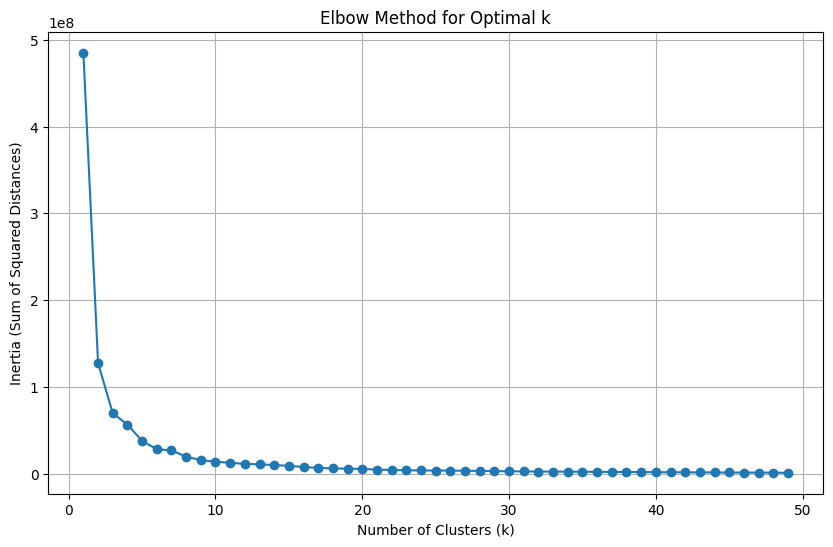

In [63]:
# Clustering based on geographical coordinates for challenge_set_updated

# Extract coordinates for adep and ades
adep_coords = challenge_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords = challenge_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Combine all coordinates for clustering
combined_coords = np.vstack((adep_coords, ades_coords))

# Calculate inertia for each k value in the specified range
inertia = []
k_range = range(1, 50)  # Testing cluster sizes from 1 to 50

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
        
# Automatically determining the optimal k using the "elbow" point
# Finding the point where the reduction in inertia slows down significantly
optimal_k = 1  # Default to 1 cluster if no elbow is detected
threshold_ratio = 0.01  # Define a threshold for identifying the elbow point

# Checking for the point where inertia reduction starts to slow down
for i in range(1, len(inertia) - 1):
    if (inertia[i - 1] - inertia[i]) > (inertia[i] - inertia[i + 1]) * threshold_ratio:
        optimal_k = i + 1
        break

In [64]:
# Apply K-means clustering on combined coordinates
kmeans_geo = KMeans(n_clusters=20, random_state=42)  
kmeans_geo.fit(combined_coords)

# Assign cluster labels back to adep and ades separately
adep_geo_labels = kmeans_geo.predict(adep_coords)
ades_geo_labels = kmeans_geo.predict(ades_coords)

# Map cluster labels to the original dataframe
challenge_set_updated['adep_geo_cluster'] = adep_geo_labels
challenge_set_updated['ades_geo_cluster'] = ades_geo_labels

In [65]:
# Clustering based on geographical coordinates for submission_set_updated

# Extract coordinates for adep and ades from submission_set_updated
adep_coords_submission = submission_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords_submission = submission_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Assign cluster labels back to adep and ades separately for submission_set_updated
adep_geo_labels_submission = kmeans_geo.predict(adep_coords_submission)
ades_geo_labels_submission = kmeans_geo.predict(ades_coords_submission)

# Map cluster labels to the submission_set_updated dataframe
submission_set_updated['adep_geo_cluster'] = adep_geo_labels_submission
submission_set_updated['ades_geo_cluster'] = ades_geo_labels_submission

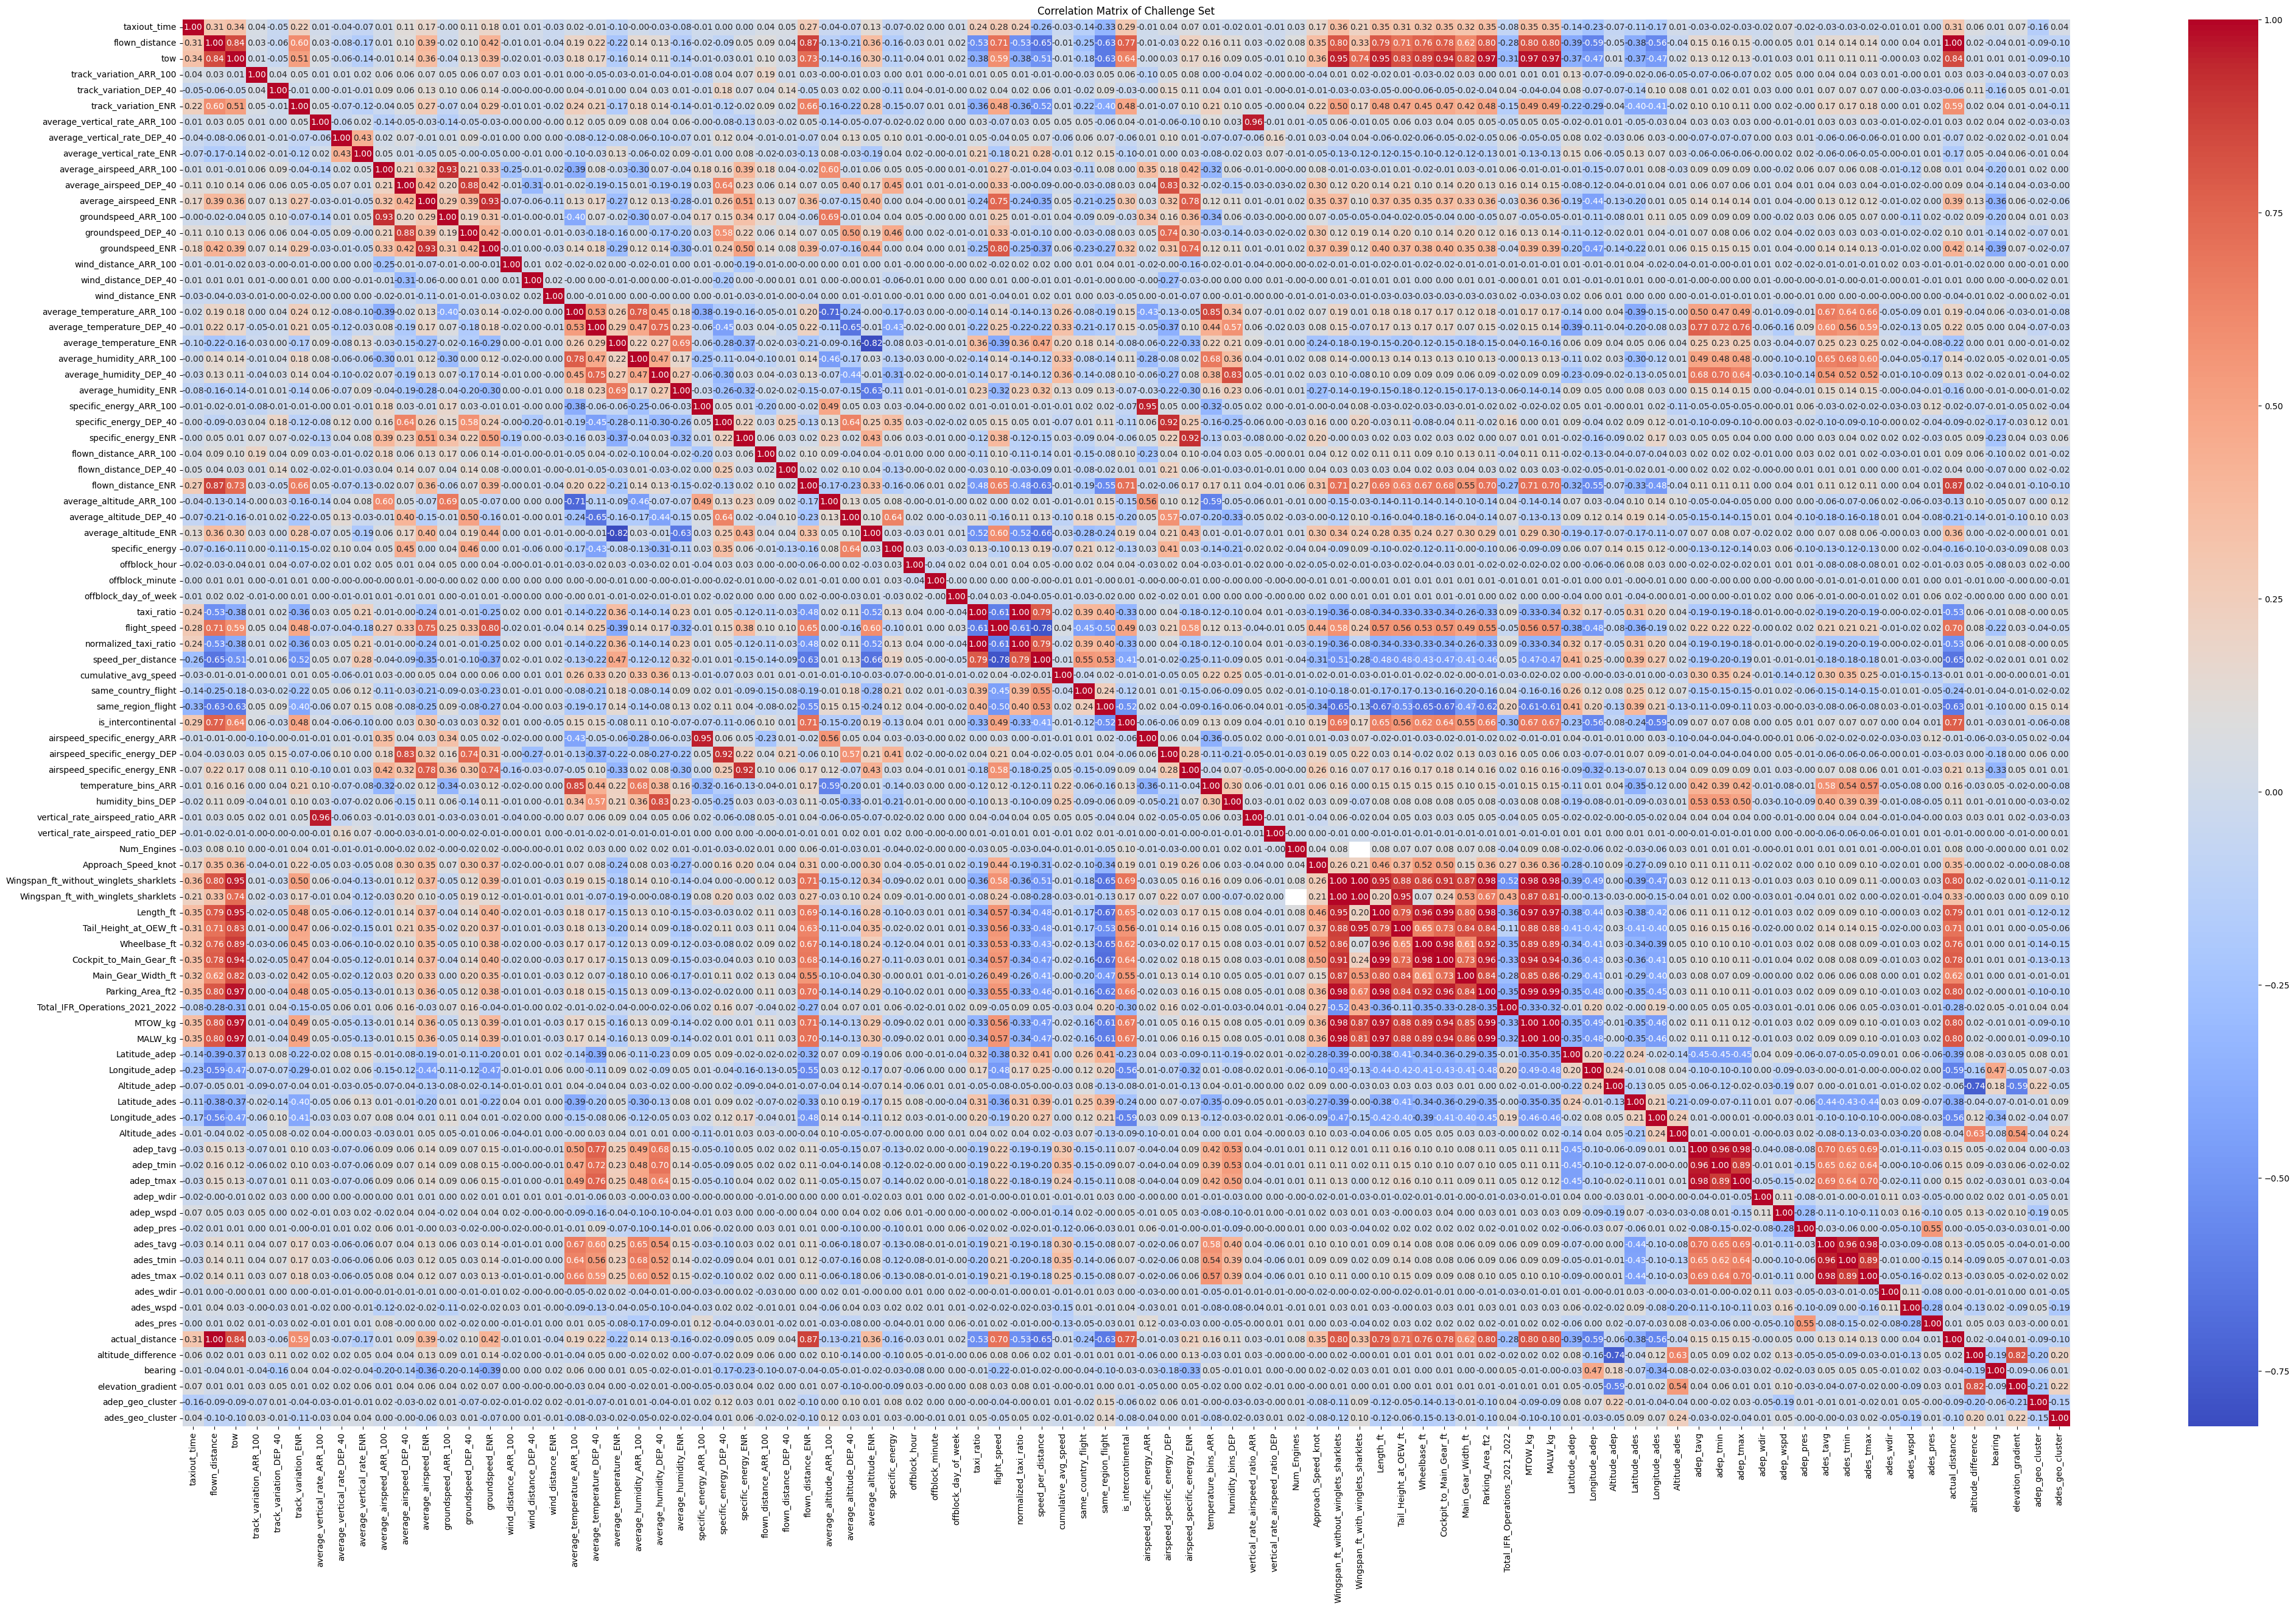

In [66]:
# Summary statistics of the challenge set
challenge_summary = challenge_set_updated.describe()

# Check for missing values
missing_values = challenge_set_updated.isnull().sum()

# Select only numerical columns
numerical_cols = challenge_set_updated.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numerical_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(50, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

In [67]:
list(challenge_set_updated.columns)

['date',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'average_altitude_ARR_100',
 'average_altitude_DEP_40',
 'average_altitude_ENR',
 'specific_energy',
 'offblock_hour',
 'offblock_minute',
 'offblock_day_of_week',


In [70]:
print(challenge_set_updated.columns.tolist())


['aircraft_type', 'wtc', 'airline', 'taxiout_time', 'flown_distance', 'tow', 'track_variation_ARR_100', 'track_variation_DEP_40', 'track_variation_ENR', 'average_vertical_rate_ARR_100', 'average_vertical_rate_DEP_40', 'average_vertical_rate_ENR', 'average_airspeed_ARR_100', 'average_airspeed_DEP_40', 'average_airspeed_ENR', 'groundspeed_ARR_100', 'groundspeed_DEP_40', 'groundspeed_ENR', 'wind_distance_ARR_100', 'wind_distance_DEP_40', 'wind_distance_ENR', 'average_temperature_ARR_100', 'average_temperature_DEP_40', 'average_temperature_ENR', 'average_humidity_ARR_100', 'average_humidity_DEP_40', 'average_humidity_ENR', 'specific_energy_ARR_100', 'specific_energy_DEP_40', 'specific_energy_ENR', 'flown_distance_ARR_100', 'flown_distance_DEP_40', 'flown_distance_ENR', 'average_altitude_ARR_100', 'average_altitude_DEP_40', 'average_altitude_ENR', 'specific_energy', 'offblock_hour', 'offblock_minute', 'offblock_day_of_week', 'taxi_ratio', 'flight_speed', 'normalized_taxi_ratio', 'flight_dur

In [71]:
# Original list of categorical columns
categorical_columns = [
    'aircraft_type', 
    'wtc', 
    'airline',
    'offblock_hour',
    'offblock_minute', 
    'offblock_day_of_week',
    'offblock_month',               # Not in DataFrame
    'offblock_week_of_year',        # Not in DataFrame
    'offblock_season',              # Not in DataFrame
    'arrival_hour',                 # Not in DataFrame
    'arrival_minute',               # Not in DataFrame
    'is_offblock_weekend',          # Not in DataFrame
    'is_offblock_rush_hour',        # Not in DataFrame
    'flight_duration_category',                       
    'adep_region', 
    'ades_region', 
    'same_country_flight',
    'same_region_flight',                        
    'flight_direction',
    'is_intercontinental',
    'temperature_bins_ARR',
    'humidity_bins_DEP',
    'Physical_Class_Engine',
    'Num_Engines',
    'Main_Gear_Config',
    'FAA_Weight',
    'adep_geo_cluster',
    'ades_geo_cluster'
]

# Filter to only include existing columns
existing_categorical_columns = [col for col in categorical_columns if col in challenge_set_updated.columns]

# Calculate the number of unique values for each categorical column efficiently
unique_variations = challenge_set_updated[existing_categorical_columns].nunique()

# Display the number of variations for each categorical variable
print(unique_variations)


aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
temperature_bins_ARR         5
humidity_bins_DEP            5
Physical_Class_Engine        2
Num_Engines                  2
Main_Gear_Config             5
FAA_Weight                   3
adep_geo_cluster            20
ades_geo_cluster            20
dtype: int64


In [75]:
# Function to rearrange the dataframe so that the target variable 'tow' is the last column
def rearrange_columns(df):
    # Moving 'tow' to the last position
    columns = [col for col in df.columns if col != 'tow'] + ['tow']
    df = df[columns]
    return df

In [76]:
# Function to check available categorical columns before encoding
def filter_existing_columns(df, columns_to_check):
    return [col for col in columns_to_check if col in df.columns]

# Check the columns in the challenge_set_updated DataFrame
print("Challenge Set Updated Columns:", challenge_set_updated.columns.tolist())

# Filter the categorical columns to only include those that exist in the DataFrame
existing_categorical_columns = filter_existing_columns(challenge_set_updated, categorical_columns)

# Apply One-Hot Encoding to the training set using the filtered columns
challenge_set_updated = pd.get_dummies(challenge_set_updated, columns=existing_categorical_columns, drop_first=True)

# Apply One-Hot Encoding to the test set
submission_set_updated = pd.get_dummies(submission_set_updated, columns=existing_categorical_columns, drop_first=True)

# Align the test set columns with the training set columns
missing_cols = set(challenge_set_updated.columns) - set(submission_set_updated.columns)
missing_cols_df = pd.DataFrame(0, index=submission_set_updated.index, columns=list(missing_cols))

# Concatenate the missing columns DataFrame with the test set
submission_set_updated = pd.concat([submission_set_updated, missing_cols_df], axis=1)

# Drop extra columns in the test set that are not in the training set
extra_cols = set(submission_set_updated.columns) - set(challenge_set_updated.columns)
submission_set_updated.drop(columns=list(extra_cols), inplace=True)

# Reorder the columns of the test set to match the training set
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

# Rearrange columns
challenge_set_updated = rearrange_columns(challenge_set_updated)
submission_set_updated = rearrange_columns(submission_set_updated)


Challenge Set Updated Columns: ['taxiout_time', 'flown_distance', 'track_variation_ARR_100', 'track_variation_DEP_40', 'track_variation_ENR', 'average_vertical_rate_ARR_100', 'average_vertical_rate_DEP_40', 'average_vertical_rate_ENR', 'average_airspeed_ARR_100', 'average_airspeed_DEP_40', 'average_airspeed_ENR', 'groundspeed_ARR_100', 'groundspeed_DEP_40', 'groundspeed_ENR', 'wind_distance_ARR_100', 'wind_distance_DEP_40', 'wind_distance_ENR', 'average_temperature_ARR_100', 'average_temperature_DEP_40', 'average_temperature_ENR', 'average_humidity_ARR_100', 'average_humidity_DEP_40', 'average_humidity_ENR', 'specific_energy_ARR_100', 'specific_energy_DEP_40', 'specific_energy_ENR', 'flown_distance_ARR_100', 'flown_distance_DEP_40', 'flown_distance_ENR', 'average_altitude_ARR_100', 'average_altitude_DEP_40', 'average_altitude_ENR', 'specific_energy', 'taxi_ratio', 'flight_speed', 'normalized_taxi_ratio', 'speed_per_distance', 'cumulative_avg_speed', 'airspeed_specific_energy_ARR', 'air

In [77]:
missing_cols

set()

In [78]:
extra_cols

set()

In [79]:
challenge_set_updated.T

0          1           2           3       \
taxiout_time                   18.0       13.0        15.0        11.0   
flown_distance                  321       4193        3770        3607   
track_variation_ARR_100  124.339907  179.31889  179.638848    0.208347   
track_variation_DEP_40    39.704139   8.910306   32.391881   36.998783   
track_variation_ENR       18.449496  76.492864   86.835411  101.712676   
...                             ...        ...         ...         ...   
ades_geo_cluster_16           False      False       False       False   
ades_geo_cluster_17           False      False       False       False   
ades_geo_cluster_18           False      False       False       False   
ades_geo_cluster_19           False      False       False       False   
tow                         54748.0   185441.0    230396.0    157615.0   

                               4           5           6           7       \
taxiout_time                     14.0        27.0        10.0        25.0   
flown_distance                    305        1434         295         458   
track_variation_ARR_100           NaN  129.426353  156.984462   17.706362   
track_variation_DEP_40     174.928513   22.836441   82.098135  178.849514   
track_variation_ENR          0.620176   16.791489   35.653151   41.002189   
...                               ...         ...         ...         ...   
ades_geo_cluster_16             False       False       False       False   
ades_geo_cluster_17             False       False       False       False   
ades_geo_cluster_18             False       False       False        True   
ades_geo_cluster_19             False       False       False       False   
tow                      70318.447226     57721.0     56818.0     60678.0   

                            8           9       ...        368361      368362  \
taxiout_time                  10.0        25.0  ...          18.0        19.0   
flown_distance                6354         257  ...           726         449   
track_variation_ARR_100  23.829551  119.350942  ...     41.225296   64.982306   
track_variation_DEP_40         NaN         NaN  ...    107.075354  174.578445   
track_variation_ENR      99.558897         NaN  ...     86.102977   59.919141   
...                            ...         ...  ...           ...         ...   
ades_geo_cluster_16          False       False  ...         False       False   
ades_geo_cluster_17          False       False  ...         False       False   
ades_geo_cluster_18          False       False  ...         False       False   
ades_geo_cluster_19          False       False  ...         False        True   
tow                       235632.0     73571.0  ...  61804.035897     72756.0   

                            368363     368364     368365      368366  \
taxiout_time                  25.0        9.0        8.0        21.0   
flown_distance                 975        782        416        4046   
track_variation_ARR_100        NaN  38.212132  70.340447  174.768738   
track_variation_DEP_40    0.397226        NaN   0.167177    5.640549   
track_variation_ENR      25.211864  28.434073  28.803271    5.110034   
...                            ...        ...        ...         ...   
ades_geo_cluster_16          False      False      False       False   
ades_geo_cluster_17          False      False      False       False   
ades_geo_cluster_18          False       True      False       False   
ades_geo_cluster_19           True      False      False       False   
tow                        73571.0    64826.0    40868.0    163438.0   

                            368367     368368        368369     368370  
taxiout_time                  25.0       11.0          12.0       16.0  
flown_distance                 946        522           466       3213  
track_variation_ARR_100   62.54495  43.910303     48.439184        NaN  
track_variation_DEP_40    7.287586  18.479277           NaN   0.612683  
track_variat

In [80]:
submission_set_updated.T

0          1          2           3       \
taxiout_time                  15.0       15.0       10.0        10.0   
flown_distance                1122       3205       3965         986   
track_variation_ARR_100        NaN  98.664855  26.478102  102.257838   
track_variation_DEP_40   57.434774  64.105402  73.771503  172.854271   
track_variation_ENR      72.127903  93.023665  27.218391   49.076097   
...                            ...        ...        ...         ...   
ades_geo_cluster_16          False      False      False       False   
ades_geo_cluster_17          False      False      False       False   
ades_geo_cluster_18          False      False      False       False   
ades_geo_cluster_19          False      False      False       False   
tow                            NaN        NaN        NaN         NaN   

                             4           5          6          7       \
taxiout_time                   15.0        15.0       10.0        9.0   
flown_distance                  686         239        251        415   
track_variation_ARR_100     5.65319  148.324583  46.441083  23.051526   
track_variation_DEP_40   131.745064  163.189758  31.596307  92.880191   
track_variation_ENR       50.971623   22.256404   8.765606   8.516241   
...                             ...         ...        ...        ...   
ades_geo_cluster_16           False       False      False      False   
ades_geo_cluster_17           False       False      False      False   
ades_geo_cluster_18           False       False      False      False   
ades_geo_cluster_19           False       False      False      False   
tow                             NaN         NaN        NaN        NaN   

                             8         9       ...     105781      105782  \
taxiout_time                   15.0      11.0  ...        5.0        15.0   
flown_distance                  321       806  ...        744        1160   
track_variation_ARR_100  115.933692       NaN  ...  25.423968  107.050329   
track_variation_DEP_40    34.157924  0.358094  ...        NaN         NaN   
track_variation_ENR        20.18134  3.002121  ...   0.498768   26.121616   
...                             ...       ...  ...        ...         ...   
ades_geo_cluster_16           False     False  ...      False       False   
ades_geo_cluster_17           False     False  ...      False       False   
ades_geo_cluster_18           False     False  ...      False       False   
ades_geo_cluster_19           False     False  ...      False       False   
tow                             NaN       NaN  ...        NaN         NaN   

                            105783     105784      105785    105786  \
taxiout_time                  25.0       35.0        10.0      15.0   
flown_distance                3540       3437        4595      1199   
track_variation_ARR_100        NaN        NaN  179.108802  7.501187   
track_variation_DEP_40   30.884164  71.774709         NaN  0.351968   
track_variation_ENR      38.182951   3.674246    4.106901  0.129044   
...                            ...        ...         ...       ...   
ades_geo_cluster_16          False      False       False     False   
ades_geo_cluster_17          False      False       False     False   
ades_geo_cluster_18          False      False       False     False   
ades_geo_cluster_19          False      False       False     False   
tow                            NaN        NaN         NaN       NaN   

                             105787     105788      105789     105790  
taxiout_time                   14.0       25.0         9.0       10.0  
flown_distance                 3937        988         240       1014  
track_variation_ARR_100   63.604558  144.75923  168.724666        NaN  
track_variation_DEP_40   130.091684    0.11828  166.830531        NaN  
track_variation_ENR      129.422361  31.815477    7.071278  33.638622  
...                             ...        ...         ...        ...  
ades

In [81]:
challenge_set_updated.to_csv('./data/challenge_set_updated_v11.csv', index=False)
submission_set_updated.to_csv('./data/submission_set_updated_v11.csv', index=False)